<a href="https://colab.research.google.com/github/prashants975/Projects_on_ML/blob/master/InstaCart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prashants975","key":"dd24bf62a12c96d43ef7ffbee0f517f8"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list -s instacart-market-basket-analysis

ref                                       title                              size  lastUpdated          downloadCount  
----------------------------------------  --------------------------------  -----  -------------------  -------------  
psparks/instacart-market-basket-analysis  Instacart Market Basket Analysis  197MB  2017-11-20 03:08:26           1886  
samwhitehill/instacart-training-sample    InstaCart training sample           1MB  2017-07-01 20:24:11             65  


In [8]:
!kaggle datasets download -d psparks/instacart-market-basket-analysis

 95% 188M/197M [00:03<00:00, 67.1MB/s]
100% 197M/197M [00:03<00:00, 52.1MB/s]


In [9]:
!unzip /content/instacart-market-basket-analysis

Archive:  /content/instacart-market-basket-analysis.zip
  inflating: order_products__train.csv  
  inflating: products.csv            
  inflating: orders.csv              
  inflating: order_products__prior.csv  
  inflating: aisles.csv              
  inflating: departments.csv         


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

## Loading the Data

In [11]:
order_products_train = pd.read_csv('/content/order_products__train.csv')
print(order_products_train.shape)
order_products_train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
products = pd.read_csv('/content/products.csv')
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
orders = pd.read_csv('/content/orders.csv')
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [14]:
order_products__prior = pd.read_csv('/content/order_products__prior.csv')
print(order_products__prior.shape)
order_products__prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [15]:
aisles = pd.read_csv('/content/aisles.csv')
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [16]:
departments = pd.read_csv('/content/departments.csv')
print(departments.shape)
departments.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## Visulaization
Lets try to find important features and relations for predicting reordering of a specific item by a users.

In [17]:
orders_test = orders[orders['eval_set'] == 'test']
print(orders_test.shape)
orders_test.head()

(75000, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [18]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

Lets see the trends in **order_numbers, order_dow, order_hour_of_day and days_since_prior_order**.<br>
We can take whole order dataframe for plotting without worrying about biases in the model for train and test as it is very small compare to the whole dataset.



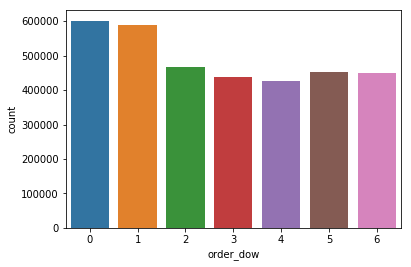

In [19]:
sns.countplot(x="order_dow", data = orders);

Number of orders reamins almost similar throughout the week except on 0 and 1 which can be the weekends representation and the day the highest amount order comes on the website.

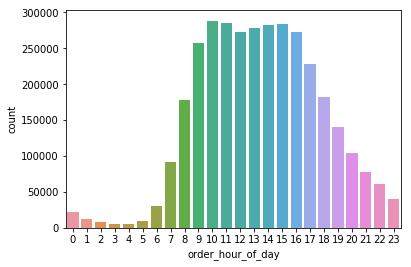

In [20]:
sns.countplot(x="order_hour_of_day", data = orders);

Most of orders frequencies are in between 8th to 19th hour.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

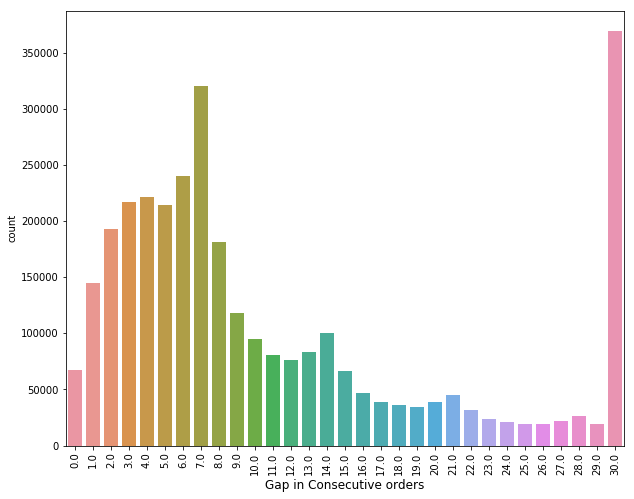

In [21]:
plt.figure(figsize=(10,8))
sns.countplot(x="days_since_prior_order", data = orders);
plt.xlabel('Gap in Consecutive orders', fontsize=12)
plt.xticks(rotation='vertical')

There is a peak at 7 day and 30 days which suggest the highest frequency for gap in consecutive orders is a week or a month. Which also shows that the users are usually order on weakly and monthly basis. 

In [22]:
order_products_train['product_id'].value_counts().head(10)

24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
47766     7409
47209     7293
16797     6494
26209     6033
27966     5546
Name: product_id, dtype: int64

In [23]:
train_full = pd.merge(order_products_train, orders,how = 'inner', on = 'order_id')
train_full = pd.merge(train_full,products ,how = 'inner', on = 'product_id')
train_full.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16


In [24]:
reorder_ratio_by_add_to_cart_order = train_full.groupby('add_to_cart_order')['reordered'].aggregate("mean").reset_index()
reorder_ratio_by_add_to_cart_order.head()


,add_to_cart_order,reordered
0,1,0.722641
1,2,0.698884
2,3,0.667972
3,4,0.646935
4,5,0.622800


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 <a list of 80 Text xticklabel objects>)

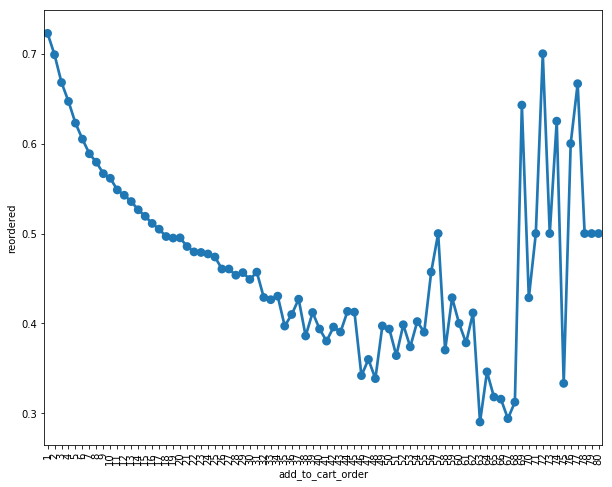

In [25]:
plt.figure(figsize = (10,8))
sns.pointplot(reorder_ratio_by_add_to_cart_order['add_to_cart_order'],reorder_ratio_by_add_to_cart_order['reordered'] );
plt.xticks(rotation='vertical')

The items that are added first in the cart have higher probability of reordering, so that looks like a good intuitive feature for our training set.<br>

In [27]:
product_group_by_reordered_ratio = train_full.groupby('product_id')['reordered'].aggregate("mean").reset_index()
product_group_by_reordered_ratio.head()

,product_id,reordered
0,1,0.644737
1,2,0.250000
2,3,1.000000
3,4,0.636364
4,5,1.000000
